In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import keras_tuner as kt

CLASSES = 2
BATCH_SIZE = 16
input_size = 244


In [2]:
tf.random.set_seed(123)
np.random.seed(123)


In [3]:
import os
import pandas as pd

def create_dataframe(data_folders, split_folders):
    dfs = []

    for data_folder in data_folders:
        for split_folder in split_folders:
            path_folder = os.path.join(data_folder, split_folder)
            image_folder = os.path.join(path_folder, 'images')
            label_folder = os.path.join(path_folder, 'labels')

            # List the files in both directories
            images = sorted(os.listdir(image_folder))
            labels = sorted(os.listdir(label_folder))

            # Create full paths for images and labels
            image_paths = [os.path.join(image_folder, img) for img in images]
            label_paths = [os.path.join(label_folder, lbl) for lbl in labels]

            x = []
            y = []
            w = []
            h = []

            # read the four indices for bounding boxes
            for label_path in label_paths:
                with open(label_path, 'r') as file:
                    # Read each line in the file one by one
                    for line in file:
                        bounding_idx = line.split(" ")

                x.append(bounding_idx[1])
                y.append(bounding_idx[2])
                w.append(bounding_idx[3])
                h.append(bounding_idx[4])

            # Create a DataFrame
            df = pd.DataFrame({
                'image_path': image_paths,
                'label_x': x,
                'label_y': y,
                'label_w': w,
                'label_h': h
            })

            dfs.append(df)

    return dfs

# Usage
data_folders = ["../../Drowsey_Driver_DL_Data/data_objectdetection/1/dl_project.v1i.yolov8", 
                "../../Drowsey_Driver_DL_Data/data_objectdetection/2/DrowsyDriverDetection.v1i.yolov8",
                "../../Drowsey_Driver_DL_Data/data_objectdetection/3/dl_images.v1i.yolov8", 
                "../../Drowsey_Driver_DL_Data/data_objectdetection/4/Drowsy Driver.v1i.yolov8"]
split_folders = ["train", "test"]

dfs = create_dataframe(data_folders, split_folders)

# Separate DataFrames for each split folder

train_dfs = dfs[:len(data_folders)]
test_dfs = dfs[len(data_folders):]

# Concatenate the DataFrames
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

# Convert columns to float
train_df[['label_x', 'label_y', 'label_w', 'label_h']] = train_df[['label_x', 'label_y', 'label_w', 'label_h']].astype(float)
test_df[['label_x', 'label_y', 'label_w', 'label_h']] = test_df[['label_x', 'label_y', 'label_w', 'label_h']].astype(float)

# Split the combined train dataframe into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Print the shapes of train and validation sets
print("Train data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
train_df.head(5)



Train data shape: (531, 5)
Validation data shape: (59, 5)


,image_path,label_x,label_y,label_w,label_h
316,../../Drowsey_Driver_DL_Data/data_objectdetect...,0.464844,0.256250,0.131250,0.135937
76,../../Drowsey_Driver_DL_Data/data_objectdetect...,0.378125,0.372656,0.375000,0.203125
529,../../Drowsey_Driver_DL_Data/data_objectdetect...,0.575781,0.282813,0.156250,0.182812
446,../../Drowsey_Driver_DL_Data/data_objectdetect...,0.532031,0.336719,0.148438,0.184375
30,../../Drowsey_Driver_DL_Data/data_objectdetect...,0.414844,0.339844,0.467969,0.093750


In [4]:
def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]

    return new_image, new_box

In [5]:
import cv2 as cv
import numpy as np
import tensorflow as tf

def data_load(df):
    X = []
    Y = []

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        # Load the image from the full path specified in the 'image_path' column
        img = cv.imread(row['image_path'], cv.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Extract bounding box coordinates from the DataFrame
        box = np.array([row['label_x'], row['label_y'], row['label_w'], row['label_h']], dtype=float)

        # Normalize the image and adjust the bounding box
        img, box = format_image(img, box)
        img = img.astype(float) / 255.0

        # convert the bounding box indices back to (0,1) scale
        box = np.asarray(box, dtype=float) / input_size

        # Append the processed image and box to the lists
        X.append(img)
        Y.append(box)

    # Convert lists to numpy arrays
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)  # Add a new axis to match the expected input shape of the model
    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = np.array(Y)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    # Create a TensorFlow Dataset from the tensor slices
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result


In [6]:
train_df = data_load(train_df)
val_df = data_load(val_df)
test_df = data_load(test_df)

2024-05-30 10:28:25.203138: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-30 10:28:25.203160: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-30 10:28:25.203163: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-30 10:28:25.203178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-30 10:28:25.203189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_df

<_TensorSliceDataset element_spec=(TensorSpec(shape=(244, 244, 1), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [8]:
def format_instance(image, label):
    # Assuming some preprocessing needed:
    # image = preprocess_image(image)  # Adjust preprocessing as necessary
    return image, [label[0], label[1], label[2], label[3]]

def tune_dataset(dataset, is_train=True):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Use generalized function for all datasets
train_ds = tune_dataset(train_df, is_train=True)
val_ds = tune_dataset(val_df, is_train=False)
test_ds = tune_dataset(test_df, is_train=False)


In [9]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

2024-05-30 10:28:26.048749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


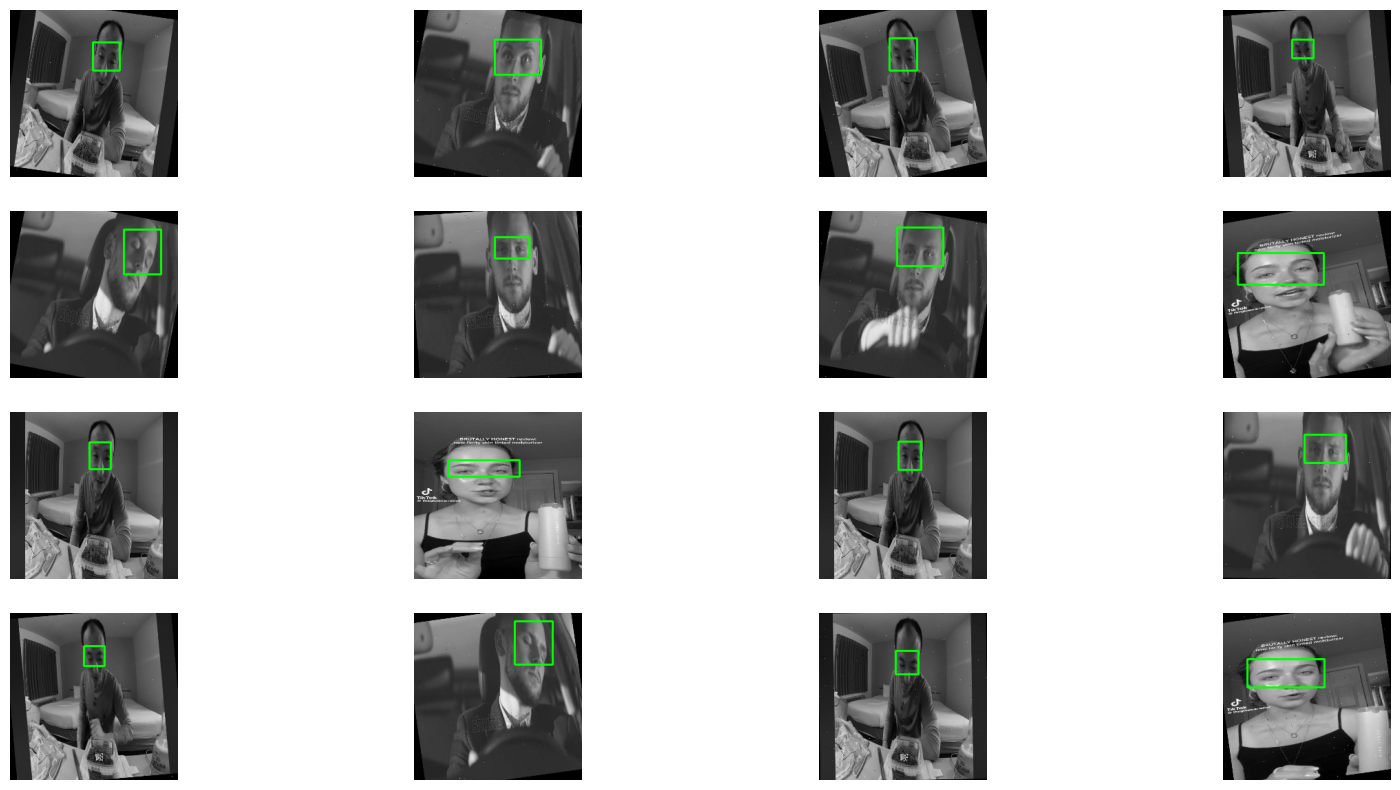

In [10]:
plt.figure(figsize=(20, 10))
for images, boxes in val_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE // 4, i + 1)

        # Retrieve the bounding box
        box = boxes[i].numpy() * input_size  # Scale the bounding box back to the original image size
        box = box.astype(int)  # Convert to integer for pixel coordinates

        # Calculate top-left and bottom-right coordinates
        x, y, w, h = box
        top_left = (x, y)
        bottom_right = (x + w, y + h)

        # Convert grayscale to RGB for visualization
        image = images[i].numpy() * 255.0  # Rescale the image
        image = image.astype(np.uint8)  # Convert to uint8 type
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        # Draw the rectangle on the image
        cv.rectangle(image_color, top_left, bottom_right, (0, 255, 0), 2)

        # Display the image
        plt.imshow(image_color)
        plt.axis("off")

plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a more complex CNN model with added regularization and dropout
model = tf.keras.models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(input_size, input_size, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(4, activation='sigmoid')
])

# Define IoU loss function
def iou_loss(y_true, y_pred):
    true_x, true_y, true_w, true_h = tf.split(y_true, 4, axis=-1)
    pred_x, pred_y, pred_w, pred_h = tf.split(y_pred, 4, axis=-1)

    intersect_x1 = tf.maximum(true_x - true_w / 2.0, pred_x - pred_w / 2.0)
    intersect_y1 = tf.maximum(true_y - true_h / 2.0, pred_y - pred_h / 2.0)
    intersect_x2 = tf.minimum(true_x + true_w / 2.0, pred_x + pred_w / 2.0)
    intersect_y2 = tf.minimum(true_y + true_h / 2.0, pred_y + pred_h / 2.0)

    intersect_area = tf.maximum(0.0, intersect_x2 - intersect_x1) * tf.maximum(0.0, intersect_y2 - intersect_y1)
    true_area = true_w * true_h
    pred_area = pred_w * pred_h
    union_area = true_area + pred_area - intersect_area
    iou = intersect_area / union_area

    return 1.0 - iou

def iou_metric(y_true, y_pred):
    true_x, true_y, true_w, true_h = tf.split(y_true, 4, axis=-1)
    pred_x, pred_y, pred_w, pred_h = tf.split(y_pred, 4, axis=-1)

    intersect_x1 = tf.maximum(true_x - true_w / 2.0, pred_x - pred_w / 2.0)
    intersect_y1 = tf.maximum(true_y - true_h / 2.0, pred_y - pred_h / 2.0)
    intersect_x2 = tf.minimum(true_x + true_w / 2.0, pred_x + pred_w / 2.0)
    intersect_y2 = tf.minimum(true_y + true_h / 2.0, pred_y + pred_h / 2.0)

    intersect_area = tf.maximum(0.0, intersect_x2 - intersect_x1) * tf.maximum(0.0, intersect_y2 - intersect_y1)
    true_area = true_w * true_h
    pred_area = pred_w * pred_h
    union_area = true_area + pred_area - intersect_area
    iou = intersect_area / union_area

    return iou

# Compile the model with IoU loss
model.compile(optimizer=Adam(learning_rate=0.001), loss=iou_loss, metrics=[iou_metric])


# Implement learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with hyperparameter tuning and learning rate scheduling
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[reduce_lr])

# Evaluate the model
loss, iou = model.evaluate(val_ds)
print("Validation IoU:", iou)

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-05-30 10:28:26.994327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - iou_metric: 0.1010 - loss: 2.4276 - val_iou_metric: 0.1661 - val_loss: 0.9691 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - iou_metric: 0.2187 - loss: 0.8999 - val_iou_metric: 0.4215 - val_loss: 0.7028 - learning_rate: 0.0010
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - iou_metric: 0.3030 - loss: 0.8173 - val_iou_metric: 0.2866 - val_loss: 0.8084 - learning_rate: 0.0010
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - iou_metric: 0.3048 - loss: 0.8030 - val_iou_metric: 0.4064 - val_loss: 0.6863 - learning_rate: 0.0010
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - iou_metric: 0.3441 - loss: 0.7546 - val_iou_metric: 0.4825 - val_loss: 0.6148 - learning_rate: 0.0010
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - iou_metric: 0.3782 - loss: 0.7159 - val_iou_metric: 0.4906 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - iou_metric: 0.4216 - 

In [12]:
model.save("detect_model.h5")

In [13]:
# Use the trained model to predict bounding box coordinates for the dataset
test_predictions = model.predict(test_ds)
test_predictions

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


array([[0.3383232 , 0.24340817, 0.33609417, 0.20196632],
       [0.3404434 , 0.24954034, 0.34215927, 0.20891763],
       [0.34415123, 0.2554696 , 0.35439563, 0.22004442],
       ...,
       [0.41032875, 0.21141592, 0.24883169, 0.19181368],
       [0.40728694, 0.21274823, 0.25139773, 0.19134669],
       [0.41795576, 0.2451992 , 0.27950138, 0.21363798]], dtype=float32)

Visualizing batch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


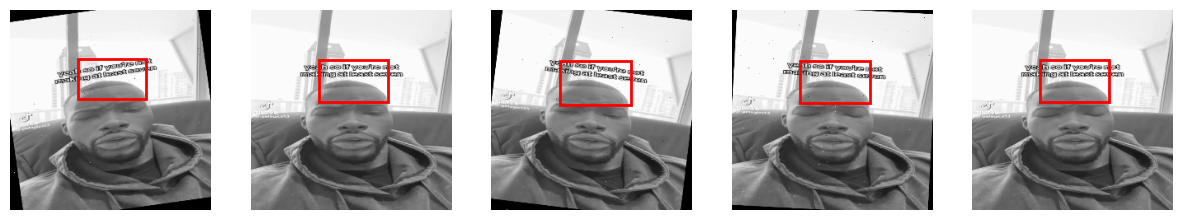

2024-05-30 10:33:06.210811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

def visualize_predictions(images, predictions, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = images[i].numpy() if isinstance(images[i], tf.Tensor) else images[i]
        img = np.squeeze(img)
        # Assuming images are in grayscale and have been normalized
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')

        # Normalize coordinates and dimensions
        x1, y1, w, h = predictions[i]
        # Adjust for image dimensions
        x1 *= img.shape[1]
        w *= img.shape[1]
        y1 *= img.shape[0]
        h *= img.shape[0]

        # Create a rectangle patch
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

    plt.show()

# Assuming 'test_ds' is your validation dataset and 'model' is your trained model
for batch_number, (images, _) in enumerate(test_ds.take(1), 1):  # Take one batch
    print(f"Visualizing batch {batch_number}")
    preds = model.predict(images)  # Predict the bounding boxes
    visualize_predictions(images, preds)  # Visualize the predictions

In [16]:
import cv2 as cv
import numpy as np

# Load the new image
image_path = "/Users/sameeraboppana/Desktop/DL_Project/PHOTO-2024-05-29-19-11-53.jpg"  # Replace this with the path to your image
new_image = cv.imread(image_path)

# Check if the image was loaded successfully
if new_image is None:
    print("Error: Unable to load image.")
else:
    # Convert the image to grayscale
    new_image_gray = cv.cvtColor(new_image, cv.COLOR_BGR2GRAY)
    
    # Preprocess the image (resize and normalize)
    resized_image = cv.resize(new_image_gray, (input_size, input_size))
    preprocessed_image = resized_image / 255.0  # Normalize the image
    
    # Reshape the image to match the input shape of the model
    input_image = np.expand_dims(preprocessed_image, axis=-1)
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    
    # Predict bounding box using the model
    predicted_boxes = model.predict(input_image)
    
    # Retrieve the bounding box predictions
    box = predicted_boxes[0] * input_size  # Scale the bounding box back to the original image size
    box = box.astype(int)  # Convert to integer for pixel coordinates
    
    # Calculate top-left and bottom-right coordinates
    x, y, w, h = box
    top_left = (x, y)
    bottom_right = (x + w, y + h)
    
    # Convert grayscale to RGB for visualization
    image_color = cv.cvtColor(resized_image, cv.COLOR_GRAY2RGB)
    
    # Draw the rectangle on the image
    cv.rectangle(image_color, top_left, bottom_right, (0, 255, 0), 2)
    
    # Display the image with bounding box
    cv.imshow("Image with Bounding Box", image_color)
    cv.waitKey(0)
    cv.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
